# Exam project - CIFAR10

## Setup

In [1]:
# Common imports
import sys
import os
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib.pyplot as plt

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action = "ignore", message = "^internal gelsd")

## Load the data
Keras has a number of functions to load popular datasets in keras.datasets. The dataset is already split for you between a training set and a test set.

In [2]:
cifar10 = keras.datasets.cifar10
(data_train_full, label_train_full), (data_test, label_test) = cifar10.load_data()

In [3]:
# Show the size and dimension of the dataset. 50k element, 32x32 images, RGB color layers
print('Full set:', data_train_full.shape)

Full set: (50000, 32, 32, 3)


In [4]:
# Split the full training set into a validation set and a (smaller) training set, and scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.0
# validate: 0-5000, train: 5000-
data_validation, data_train = data_train_full[:5000] / 255.0, data_train_full[5000:] / 255.0 
label_validation, label_train = label_train_full[:5000], label_train_full[5000:]
data_test = data_test / 255.0

In [5]:
print('Train:', data_train.shape)
print('Validate:', data_validation.shape)

Train: (45000, 32, 32, 3)
Validate: (5000, 32, 32, 3)


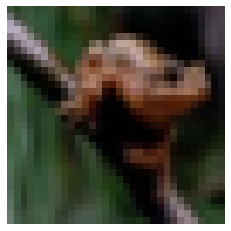

In [6]:
#Plot an image using Matplotlib's imshow() function
plt.imshow(data_train[0])
plt.axis('off')
plt.show()

In [7]:
class_names = ["Airplane", "Automobile", "Bird", "Cat", "Deer",
               "Dog", "Frog", "Horse", "Ship", "Truck"]
class_names[label_train[0][0]]

'Frog'

## Standardize the data
Because we want to use the SELU activation function and LeCun weight initializer, we should standardize all the input features to a mean of 0 and a standard deviation of 1. Since each pixel is an input feature, there are 28x28=784 input features, and we need to compute the mean and standard deviation for each of them.

In [8]:
# Compute the mean for each pixel.
pixel_means = data_train.mean(axis = 0, keepdims = True)
print('Means:', pixel_means.shape)

# Compute the standard deviation for each pixel.
pixel_stds = data_train.std(axis = 0, keepdims = True)
print('Standard deviation:', pixel_stds.shape)

Means: (1, 32, 32, 3)
Standard deviation: (1, 32, 32, 3)


In [9]:
# Scale the inputs to mean 0 and standard deviation 1 to achieve self-normalization with SELU and LeCun.
data_train_standardized = (data_train - pixel_means) / pixel_stds
data_validation_standardized = (data_validation - pixel_means) / pixel_stds
data_test_standardized = (data_test - pixel_means) / pixel_stds

In [10]:
# Validate that the mean is close to 0 for each pixel.
data_train_standardized.mean(axis = 0, keepdims = True)

array([[[[-1.26346538e-14,  3.83544900e-14, -1.45948340e-14],
         [ 2.16892529e-14,  3.88299911e-14,  2.69281881e-14],
         [ 3.47678923e-15,  4.16193598e-14,  3.18685522e-14],
         ...,
         [ 1.76495559e-14,  6.61919458e-14,  2.21680353e-14],
         [ 1.66235371e-14,  4.96447476e-14,  3.16723191e-14],
         [ 5.35746262e-15,  4.45144613e-14,  1.94159799e-14]],

        [[-1.99349722e-14, -3.55779603e-15,  4.97943415e-15],
         [ 8.87647980e-15,  5.65033699e-14,  3.09045777e-14],
         [-5.48222702e-15,  5.33282455e-14,  1.60781906e-14],
         ...,
         [ 1.28854458e-15,  1.69432073e-14,  1.56435655e-14],
         [-5.75694554e-15,  1.82706147e-14, -1.09884447e-15],
         [-4.67727092e-15,  2.91203851e-14,  1.43271271e-14]],

        [[-2.38230916e-14,  2.39115740e-14,  1.65502476e-14],
         [ 1.54112772e-15,  5.32304225e-14,  3.12234189e-16],
         [ 1.71493387e-14,  4.50213447e-14,  7.41992640e-15],
         ...,
         [-1.77874505e-1

In [11]:
# Validate that the standard deviation is close to 1 for each pixel.
data_train_standardized.std(axis = 0, keepdims = True)

array([[[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        ...,

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]]])

## Create a model using the Sequential API

In [79]:
model = keras.models.Sequential()

# Input layer:
model.add(keras.layers.Flatten(input_shape = [32, 32, 3]))

# Hidden layers:
model.add(keras.layers.Dense(500, activation = "selu", kernel_initializer = "lecun_normal"))
# model.add(keras.layers.Dense(100, activation = "selu", kernel_initializer = "lecun_normal"))

# Use alpha dropout in the last hidden layer.
model.add(keras.layers.AlphaDropout(rate = 0.2))
    
# Output layer.
model.add(keras.layers.Dense(10, activation = "softmax"))

## Compile the model
You must at least specify the loss function and the optimizer to use. You can also specify a list of additional metrics to use during training and evaluation.

In [80]:
# The optimixer is Stochastic Gradient Descent with momentum optimization. The momentum is set to 0.9.
# This value usually works well in practice. We use the default learning rate (0.01).
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(lr = 5e-4,momentum = 0.9),
              metrics = ["accuracy"])

In [81]:
# EarlyStopping (with rollback to the best model).
early_stopping = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

# Performance scheduling (multiply the learning rate by a factor when the error stops dropping for a number of epochs, called patience)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience = 4)

# Train the model with early stopping or performance scheduling or both. Training is much faster when early stopping is used, but a slightly better accuracy is achieved with performance scheduling alone.
history = model.fit(data_train_standardized, label_train, epochs = 50,
                    validation_data = (data_validation_standardized, label_validation),
                    callbacks = [early_stopping, lr_scheduler])

Epoch 1/50
1407/1407 [==============================] - 7s 5ms/step - loss: 1.9801 - accuracy: 0.3288 - val_loss: 1.6634 - val_accuracy: 0.4388
Epoch 2/50
1407/1407 [==============================] - 7s 5ms/step - loss: 1.6826 - accuracy: 0.4102 - val_loss: 1.5985 - val_accuracy: 0.4502
Epoch 3/50
1407/1407 [==============================] - 7s 5ms/step - loss: 1.5869 - accuracy: 0.4432 - val_loss: 1.5549 - val_accuracy: 0.4730
Epoch 4/50
1407/1407 [==============================] - 7s 5ms/step - loss: 1.5201 - accuracy: 0.4674 - val_loss: 1.5115 - val_accuracy: 0.4828
Epoch 5/50
1407/1407 [==============================] - 7s 5ms/step - loss: 1.4714 - accuracy: 0.4804 - val_loss: 1.4876 - val_accuracy: 0.4920
Epoch 6/50
1407/1407 [==============================] - 7s 5ms/step - loss: 1.4329 - accuracy: 0.4935 - val_loss: 1.4564 - val_accuracy: 0.5032
Epoch 7/50
1407/1407 [==============================] - 7s 5ms/step - loss: 1.3924 - accuracy: 0.5079 - val_loss: 1.4565 - val_accuracy:

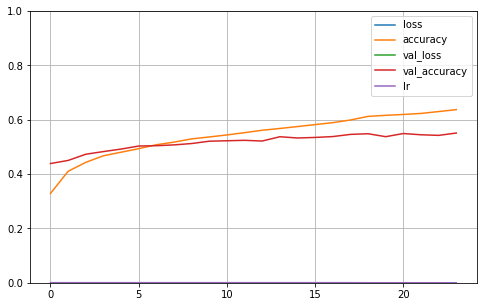

In [82]:
# Show the learning curves.
# (The training curves should be shifted half an epoch to the left to be completely comparable with the validation curves).

pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [83]:
model.evaluate(data_test_standardized, label_test)

313/313 [==============================] - 0s 1ms/step - loss: 1.4117 - accuracy: 0.5416


[1.4117159843444824, 0.5415999889373779]